In [1]:
import requests
import re
from itertools import combinations
from bs4 import BeautifulSoup

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.patheffects as pe
from PIL import Image

import numpy as np

import time

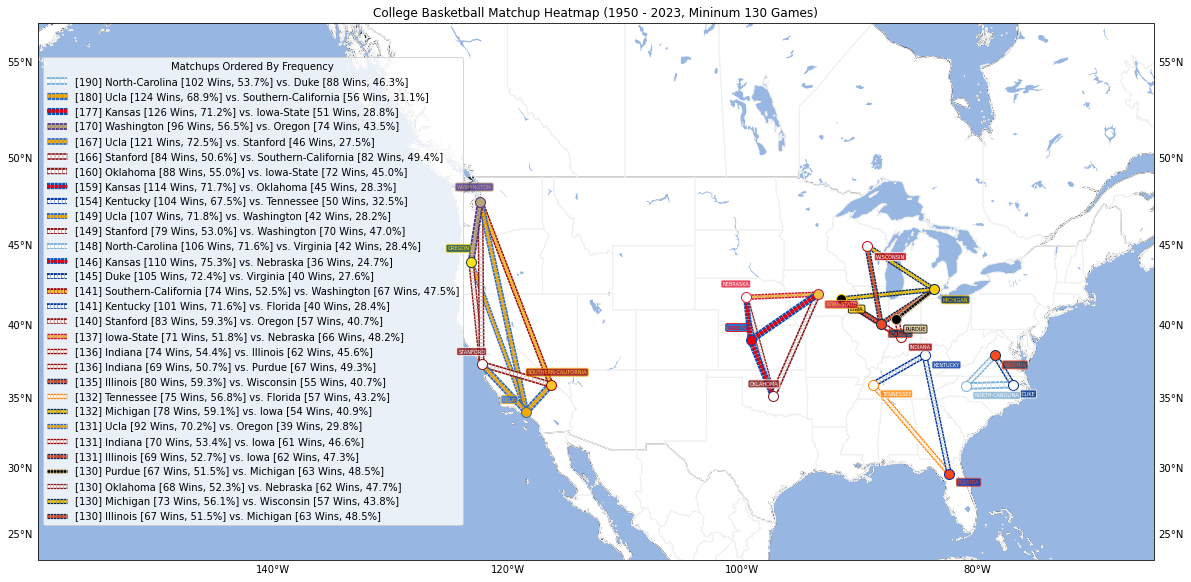

--- 13.214202642440796 seconds ---


In [10]:
start_time = time.time()

maptype = ccrs.Mercator()
#Mercator #Miller #InterruptedGoodeHomolosine

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=maptype)
ax.set_global() 
ax.coastlines() 
ax.set_extent([-160,-65,23,46]) #set range of what the global map shows (mainland US)
ax.add_feature(cfeature.BORDERS) #add country borders
ax.add_feature(cfeature.OCEAN) #add oceans
ax.add_feature(cfeature.LAKES) #add lakes
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='#f0f0f0') # gray state borders

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle=':')
gl.xlines = False
gl.ylines = False
gl.top_labels = False

teams = {
    'pittsburgh' : {'lat' : 40.44, 'lon' : -80, 'color1' : '#003594', 'color2': '#FFB81C'},
    'syracuse' : {'lat' : 43, 'lon' : -76.1, 'color1' : '#F76900', 'color2' : '#000E54'},
    'duke' : {'lat' : 36, 'lon' : -77, 'color1' : '#003087', 'color2' : 'white'},
    'north-carolina' : {'lat' : 35.9, 'lon' : -81, 'color1' : '#7BAFD4', 'color2' : 'white'},
    'stanford' : {'lat' : 37.4, 'lon' : -122.2, 'color1' : '#8C1515', 'color2' : 'white'},
    'ucla' : {'lat' : 34.1, 'lon' : -118.4, 'color1' : '#2D68C4', 'color2' : '#F2A900'},
    'kentucky' : {'lat' : 38.0, 'lon' : -84.5, 'color1' : '#0033A0', 'color2' : 'white'},
    'texas' : {'lat' : 30.3, 'lon' : -97.7, 'color1' : '#BF5700', 'color2' : 'white'},
    'indiana' : {'lat' : 39.2, 'lon' : -86.5, 'color1' : '#990000', 'color2' : 'white'},
    'wisconsin' : {'lat' : 45.0, 'lon' : -89.4, 'color1' : '#C5050C', 'color2' : 'white'},
    'michigan' : {'lat' : 42.3, 'lon' : -83.7, 'color1' : '#00274C', 'color2' : '#FFCB05'},
    'florida' : {'lat' : 29.6, 'lon' : -82.4, 'color1' : '#0021A5', 'color2' : '#FA4616'},
    'oklahoma' : {'lat' : 35.2, 'lon' : -97.4, 'color1' : '#841617', 'color2' : 'white'},
    'illinois' : {'lat' : 40.1, 'lon' : -88.2, 'color1' : '#13294B', 'color2' : '#E84A27'},
    'purdue' : {'lat' : 40.4, 'lon' : -86.9, 'color1' : '#CEB888', 'color2' : 'black'},
    'iowa' : {'lat' : 41.7, 'lon' : -91.6, 'color1' : '#FFCD00', 'color2' : 'black'},
    'iowa-state' : {'lat' : 42.0, 'lon' : -93.6, 'color1' : '#C8102E', 'color2' : '#F1BE48'},
    'kansas' : {'lat' : 39.0, 'lon' : -99.3, 'color1' : '#0051BA', 'color2' : '#E8000D'},
    'arizona' : {'lat' : 32.2, 'lon' : -111.0, 'color1' : '#CC0033', 'color2' : '#003366'},
    'tennessee' : {'lat' : 36.0, 'lon' : -88.9, 'color1' : '#FF8200', 'color2' : 'white'},
    'miami-fl' : {'lat' : 25.7, 'lon' : -80.3, 'color1' : '#F47321', 'color2' : '#005030'},
    'new-mexico' : {'lat' : 35.1, 'lon' : -106.6, 'color1' : '#BA0C2F', 'color2' : '#A7A8AA'},
    'georgetown' : {'lat' : 38.9, 'lon' : -77.1, 'color1' : 'blue', 'color2' : 'white'},
    'penn-state' : {'lat' : 40.8, 'lon' : -77.9, 'color1' : '#041E42', 'color2' : 'white'},
    'notre-dame' : {'lat' : 41.7, 'lon' : -86.2, 'color1' : '#0C2340', 'color2' : '#C99700'},
    'virginia' : {'lat' : 38.0, 'lon' : -78.5, 'color1' : '#232D4B', 'color2' : '#F84C1E'},
    'washington' : {'lat' : 47.6, 'lon' : -122.3, 'color1' : '#4B2E83', 'color2' : '#B7A57A'},
    'southern-california' : {'lat' : 36.0, 'lon' : -116.3, 'color1' : '#990000', 'color2' : '#FFC72C'},
    'nebraska' : {'lat' : 41.8, 'lon' : -99.7, 'color1' : '#E41C38', 'color2' : 'white'},
    'louisville' : {'lat' : 38.2, 'lon' : -85.8, 'color1' : '#AD0000', 'color2' : 'black'},
    'oregon' : {'lat' : 44.0, 'lon' : -123.1, 'color1' : '#154733', 'color2' : '#FEE123'},
}

# https://www.geeksforgeeks.org/python-all-possible-pairs-in-list/
names_list = teams.keys()
team_pairs = list(combinations(names_list, 2))

for team_pair in team_pairs:
    team_pair = sorted(team_pair) #ALPHABETIZE SO THERE ARE NO DUPLICATE ENTRIES IN THE TEXT FILE
    team1 = team_pair[0]
    team2 = team_pair[1]
    
    num_matches_in_file = 0
    
    with open('matchups.txt', 'r') as r:
        for matchup in r:
            if team1 == matchup.split(',')[0] and team2 == matchup.split(',')[2]:
                num_matches_in_file += 1
    if num_matches_in_file == 0:
        # plugging in team1 and team2 to this url:
        base_url = "https://www.sports-reference.com/cbb/play-index/matchup_finder.cgi?request=1&year_min=1950&year_max=2023&comp_school=le&rank_school=ANY&comp_opp=le&rank_opp=ANY&school_id="+team1+"&opp_id="+team2+"&game_type=A&order_by=date_game"
        page = requests.get(base_url)
        soup = BeautifulSoup(page.content, 'html.parser')
        # https://stackoverflow.com/questions/20293792/how-to-select-div-by-text-content-using-beautiful-soup

        try:
            wins_losses_element = soup.find_all(text=re.compile('W%')) #searching for specific string for info I want
            wins_losses_string = wins_losses_element[0]
            wins_losses_split = wins_losses_string.split(',')
            team1_wins = int(wins_losses_split[0].split()[0])
            team2_wins = int(wins_losses_split[1].split()[0])

            total_games = team1_wins+team2_wins
            print(team1, "[", team1_wins, "]", "vs.", team2, "[", team2_wins, "]", "=", total_games, "total games")

            #print("--- %s seconds ---" % (time.time() - start_time))
            if len(names_list) >= 20:
                time.sleep(3)

            current_matchup = team1+','+str(team1_wins)+','+team2+','+str(team2_wins)

        except IndexError:
            print(team1, "vs.", team2, ":", 'error')
            current_matchup = team1+','+'0'+','+team2+','+'0' #placeholder 0s
            if len(names_list) > 19:
                time.sleep(3)
                
        with open ('matchups.txt', 'a') as a:
            a.write("\n");
            a.write(current_matchup)
            
#PRINTING LINES

included_teams = []

with open('matchups.txt', 'r') as r:
    for matchup in r:
        
        team1 = matchup.split(',')[0]
        team2 = matchup.split(',')[2]
        
        if team1 in names_list and team2 in names_list: #allows you to hide different teams that are already catalogued
            team1_wins = int(matchup.split(',')[1])
            team2_wins = int(matchup.split(',')[3])
            total_games = team1_wins + team2_wins

            thickness = total_games/50

            lat1 = teams[team1]['lat']
            lon1 = teams[team1]['lon']

            lat2 = teams[team2]['lat']
            lon2 = teams[team2]['lon']

            if team1_wins > team2_wins :
                winning_team = team1
                losing_team = team2
                more_wins = team1_wins
                less_wins = team2_wins
            else :
                winning_team = team2
                losing_team = team1
                more_wins = team2_wins
                less_wins = team1_wins
                
            winning_percent = str(round(100*(more_wins)/(total_games+.01), 1))
            losing_percent = str(round(100*(less_wins)/(total_games+.01), 1))

            color1 = teams[winning_team]['color1']
            color2 = teams[winning_team]['color2']

            if total_games > 100:
                label = '['+str(total_games)+'] '+winning_team.title()+" ["+str(more_wins)+" Wins, "+winning_percent+"%]"+" vs. "+losing_team.title()+" ["+str(less_wins)+" Wins, "+losing_percent+"%]"
            else:
                label = '_nolegend_'
                    
            if total_games >= 130:
                if team1 not in included_teams:
                    included_teams.append(team1)
                if team2 not in included_teams:
                    included_teams.append(team2)
                
                ax.plot([lon1, lon2], [lat1, lat2], linestyle='solid', alpha=1, linewidth=thickness, transform=ccrs.PlateCarree(), color=color2, zorder=total_games+10, dashes=[1, 30/total_games], path_effects=[pe.Stroke(linewidth=thickness*2, foreground=color1), pe.Normal()], label=label)

#PRINTING TEAM NAME LABELS AND POINTS
for team in teams :
    if team in included_teams:
        lat = teams[team]['lat']
        lon = teams[team]['lon']
        color1 = teams[team]['color1']
        color2 = teams[team]['color2']
        if lon < -95:
            horizontal_offset = -2
            vertical_offset = .75
        else:
            horizontal_offset = .75
            vertical_offset = -.75
        ax.annotate(team.upper(), xy=(lon+horizontal_offset, lat+vertical_offset), color=color2, transform=ccrs.Geodetic(), bbox=dict(facecolor=color1, edgecolor=color2, boxstyle='round', alpha=.8), zorder=500, fontsize=5)
        ax.scatter(lon,lat,color=color2,s=100,alpha=1,transform=ccrs.Geodetic(), marker='o', zorder=500, edgecolor=color1) 

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels, loc='center left', title='Matchups Ordered By Frequency')
    
ax.set_title('College Basketball Matchup Heatmap (1950 - 2023, Mininum 130 Games)')
plt.savefig('export-'+str(time.time())+'.pdf')
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))


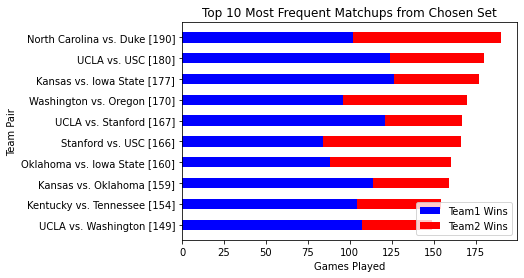

In [13]:
matchups = ['North Carolina vs. Duke [190]', 
     'UCLA vs. USC [180]', 
     'Kansas vs. Iowa State [177]', 
     'Washington vs. Oregon [170]', 
     'UCLA vs. Stanford [167]', 
     'Stanford vs. USC [166]', 
     'Oklahoma vs. Iowa State [160]', 
     'Kansas vs. Oklahoma [159]', 
     'Kentucky vs. Tennessee [154]', 
     'UCLA vs. Washington [149]']

matchups.reverse()
 
#win_counts = {
  #  "Team1 Wins": np.array([102, 124, 126, 96, 121, 84, 88, 114, 104, 107]),
  #  "Team2 Wins": np.array([88, 56, 51, 74, 46, 82, 72, 45, 50, 42]),
#}

win_counts = {
    "Team1 Wins": np.array([107, 104, 114, 88, 84, 121, 96, 126, 124, 102]),
    "Team2 Wins": np.array([42, 50, 45, 72, 82, 46, 74, 51, 56, 88]),
}
width = 0.5

fig, ax = plt.subplots()
left = np.zeros(len(matchups))

team_position = 0

for boolean, win_count in win_counts.items():
    if team_position == 0:
        color = 'blue'
    else:
        color = 'red'
    p = ax.barh(matchups, win_count, width, label=boolean, left=left, color=color)
    left += win_count
    team_position +=1

ax.set_title("Top 10 Most Frequent Matchups from Chosen Set")
ax.legend(loc="lower right")

plt.xlabel('Games Played')
plt.ylabel('Team Pair')

plt.show()
